<a href="https://colab.research.google.com/github/Koushouu/Bioimage-Analysis-Workshop-Taipei/blob/main/Cellpose_2_0_in_colab_part_1_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose 2.0 in colab - part 1

In this notebook we will run cellpose segmentation on our sample images, with the model provided by cellpose. There is also an option to segment with our own custom model, the methods to make your own model will be covered in another notebook. 

If your notebook is in Chinese please go to "説明" tab above and select "查看英文版本"

There are two sections in this notebook:

* Section 1 - Setup: we will install cellpose 2.0 and openCV to our runtime. And we will initialize the colab cloud GPU

* Section 2 - Cellpose segmentation with pretrained or custom models: We will segment our custom image in this section, and we will show the segmentation result with matplotlib

The content of this notebook is mostly modified from: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb

# Setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 171 kB 12.3 MB/s 
     |████████████████████████████████| 36.4 MB 300 kB/s 
     |████████████████████████████████| 4.9 MB 52.9 MB/s 


Check CUDA version and that GPU is working in cellpose and import other libraries. If your GPU activation failed its probably due to the wrong runtime type during setup. Go to Runtime tab above -> Change Runtime Type -> Hardware Accelerator -> GPU

In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
Fri Dec 23 07:56:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |      

## Connect your Google Drive to Colab

Mount your google drive and find your working folder with (if available) the model that you trained. If you want to train a model, create a folder in google drive with the images and the labels ( `_seg.npy` files from the cellpose gui)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Use pretrained or custom model to segment images

## Model parameters:

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`moodel_path`:** Full path to the custum trained model

You should leave one of them empty

In [ ]:
# model name and path

#@markdown ###Pretrained model name from model zoo:

initial_model = "cyto2" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch'] {type:"string"}

#@markdown ###or Custom model path (full path):

model_path = "" #@param {type:"string"}

#@markdown ###Path to images:

dir = "/content/gdrive/MyDrive/Colab Notebooks/example_data" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "None" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  40#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

## run model

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# set channels
channels = [chan, chan2]

# declare model
if model_path =="":
  model = models.CellposeModel(gpu=True, 
                             model_type=initial_model)
else: 
  model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['/content/gdrive/MyDrive/Colab Notebooks/example_data/example_cells_1.tif', '/content/gdrive/MyDrive/Colab Notebooks/example_data/example_cells_2.tif']


100%|██████████| 25.3M/25.3M [00:03<00:00, 7.86MB/s]


## Show results with matplotlib

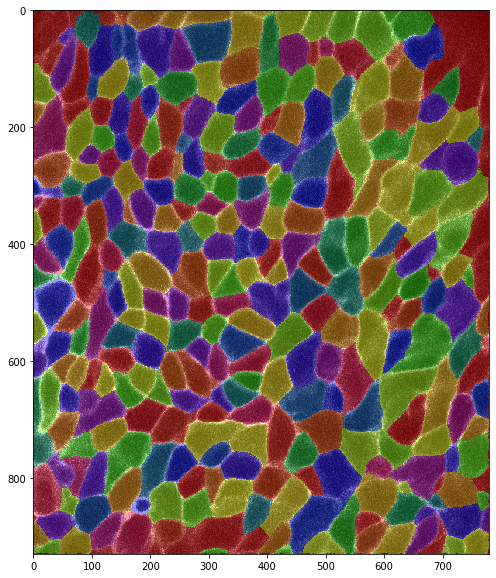

In [ ]:
from skimage.io import imread
# read both the images and the segmentation results
image_id = 1
# Show the image
plt.figure(figsize=(10,10))
plt.imshow(images[image_id], interpolation='none', cmap='gray')
plt.imshow(masks[image_id], interpolation='none', cmap='prism', alpha=0.4)
plt.show()

## save output to *_seg.npy

you will see the files save in the folder where your test image is located (Might need to wait for a min or two to have it appear on your drive folder)

In [ ]:
from cellpose import io

io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      diameter*np.ones(len(masks)), 
                      files, 
                      channels)

## save output masks

Output masks (segmentations) can be saved in png/tif/txt for futher processing in imageJ or other python scripts.

In [ ]:
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=channels,
              png=False, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=False, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs 
              )